<a href="https://colab.research.google.com/github/andrewcxjin/aipi590-xai/blob/main/mechanistic_interp_Jin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mechanistic Interpretability**

This notebook will show the process of building a tiny neural network and exploring how it works from the inside. We will train the network on modular artihmetic. More specifically we will work with computing (a + b) mod 10 for single digits.

#### 📝 Note
My Colab has a built in assistant from Gemini that provided suggestions on the code. This notebook was started from the starter notebook provided in the course Github. I used Claude to help me brainstorm toy tasks, which is how I reached modular arithmetic. I also used it to debug parts of my code throughout the notebook. Some code was taken from my previous work in an undergraduate class that also taught about neural networks. The markdown explanations were written in my own words with no AI assistance.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import train_test_split

## Part 1 - Setup

### Data Generation

In [45]:
def generate_data():
    X = []
    y = []

    for a in range(10):
      for b in range(10):
        input = np.zeros(20)
        input[a] = 1
        input[10 + b] = 1

        target = (a + b) % 10

        X.append(input)
        y.append(target)

    return torch.FloatTensor(X), torch.LongTensor(y)

X_train, y_train = generate_data()

### Build a Tiny MLP (multilayer perceptron) Model

In [46]:
class ModularArithmetic(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(20, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 10)

        self.hidden_activations = None

    def forward(self, x):
        h = self.fc1(x)
        h_activated = self.relu(h)
        self.hidden_activations = h_activated

        out = self.fc2(h_activated)
        return out, h  # for interpretability

    def get_hidden_activations(self):
        return self.hidden_activations

# Instantiate model
model = ModularArithmetic(hidden_dim=16)
print(model)


ModularArithmetic(
  (fc1): Linear(in_features=20, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)


In [47]:
def train_model(model, X, y, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []
    for epoch in range(500):
        out, _ = model(X)
        loss = criterion(out, y)

        _, preds = torch.max(out, dim=1)
        accuracy = (preds == y).float().mean().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        accuracies.append(accuracy)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}, Accuracy: {accuracy:.2%}")

    return losses, accuracies

print("Training the model...")
losses, accuracies = train_model(model, X_train, y_train, 500, 0.01)

print(f"\nFinal accuracy: {accuracies[-1]:.2%}")


Training the model...
Epoch [50/500] Loss: 1.6189, Accuracy: 53.00%
Epoch [100/500] Loss: 0.6702, Accuracy: 88.00%
Epoch [150/500] Loss: 0.2340, Accuracy: 100.00%
Epoch [200/500] Loss: 0.0912, Accuracy: 100.00%
Epoch [250/500] Loss: 0.0473, Accuracy: 100.00%
Epoch [300/500] Loss: 0.0296, Accuracy: 100.00%
Epoch [350/500] Loss: 0.0204, Accuracy: 100.00%
Epoch [400/500] Loss: 0.0148, Accuracy: 100.00%
Epoch [450/500] Loss: 0.0114, Accuracy: 100.00%
Epoch [500/500] Loss: 0.0091, Accuracy: 100.00%

Final accuracy: 100.00%


### Examples

In [48]:
def test_model(model, num_tests):
    model.eval()
    print("Testing the model...")

    for i in range(num_tests):
        a, b = np.random.randint(0, 10, 2)

        input = torch.zeros(20)
        input[a] = 1
        input[10 + b] = 1

        with torch.no_grad():
            out, _ = model(input.unsqueeze(0))
            pred = torch.argmax(out).item()

        true = (a + b) % 10

        print(f"Input: {a} + {b} = {true}, Prediction: {pred}")

test_model(model, 10)

Testing the model...
Input: 2 + 7 = 9, Prediction: 9
Input: 7 + 9 = 6, Prediction: 6
Input: 9 + 4 = 3, Prediction: 3
Input: 9 + 3 = 2, Prediction: 2
Input: 5 + 7 = 2, Prediction: 2
Input: 6 + 0 = 6, Prediction: 6
Input: 1 + 3 = 4, Prediction: 4
Input: 7 + 6 = 3, Prediction: 3
Input: 8 + 8 = 6, Prediction: 6
Input: 0 + 6 = 6, Prediction: 6


## Part 2 & 3 - Explore & Explain

### Plot hidden activations across different pairs

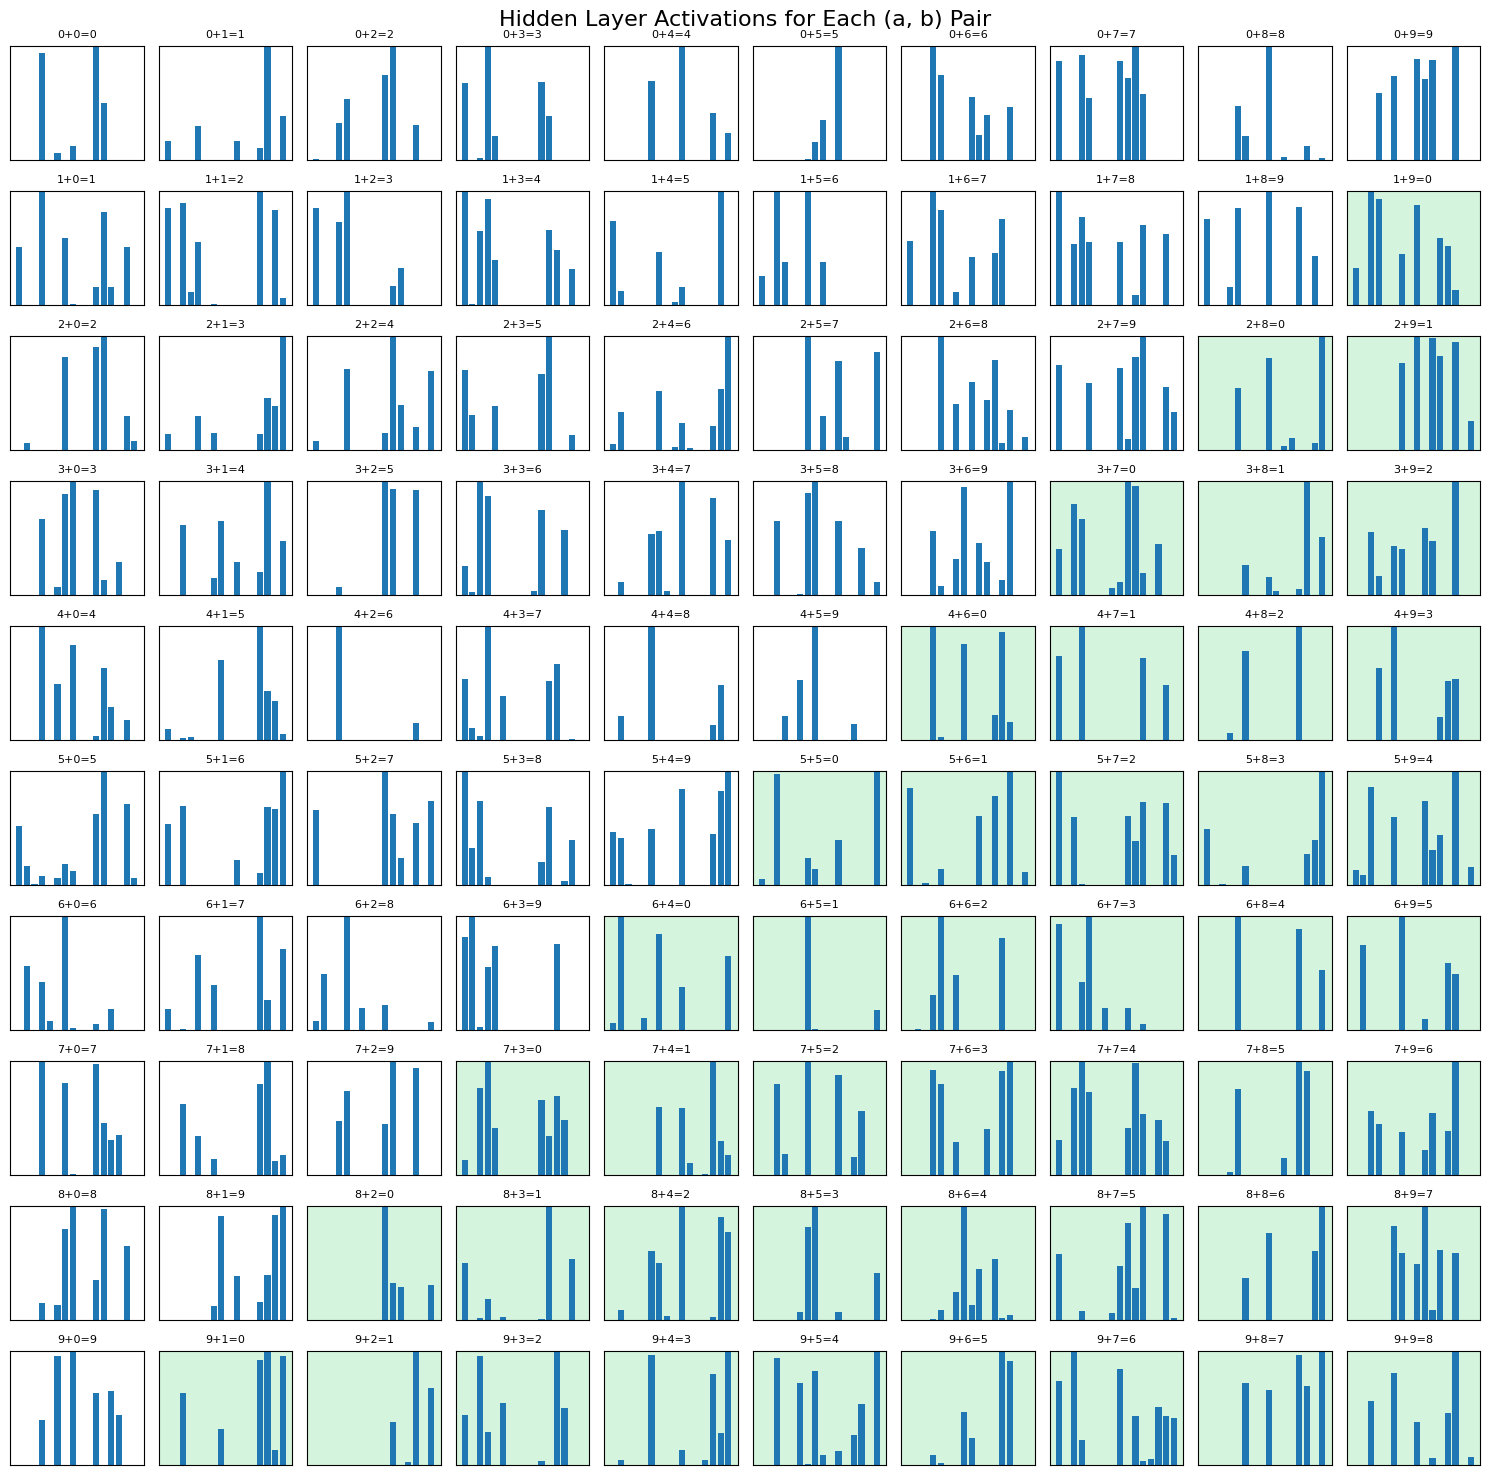

In [73]:
def get_activations(model, X):
    model.eval()
    activations = []

    with torch.no_grad():
        for x in X:
            _ = model(x.unsqueeze(0))
            activations.append(model.get_hidden_activations().cpu().numpy().squeeze())

    return np.array(activations)

# Collect activations
all_activations = get_activations(model, X_train)

# Create grid
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
fig.suptitle('Hidden Layer Activations for Each (a, b) Pair', fontsize=16)

for a in range(10):
    for b in range(10):
        idx = a * 10 + b
        ax = axes[a, b]

        # Plot activation pattern
        activations = all_activations[idx]
        ax.bar(range(len(activations)), activations)
        ax.set_ylim([0, max(activations.max(), 1)])
        ax.set_title(f'{a}+{b}={(a+b)%10}', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])

        # Highlight if result involves wraparound
        if a + b >= 10:
            ax.patch.set_facecolor('#d4f4dd')

plt.tight_layout()
plt.show()

Since we only have 100 possible combinations, we can plot a bar graph for each possible pair to see which neurons are activated. Furthermore, with modular arithmetics we have wraparound cases where the number will cycle back to 0 after it reaches a sum greater than 10, which is our mod value. Skimming over the bar graphs, there seems to be no trend among the activated neurons based on the pair or wraparound. As we are looking at 100 bar graphs which can be overwhelming, we can utilize other visualization techniques to do a deeper exploration on the activity of each neuron.

## Plot neurons' reponse to sums

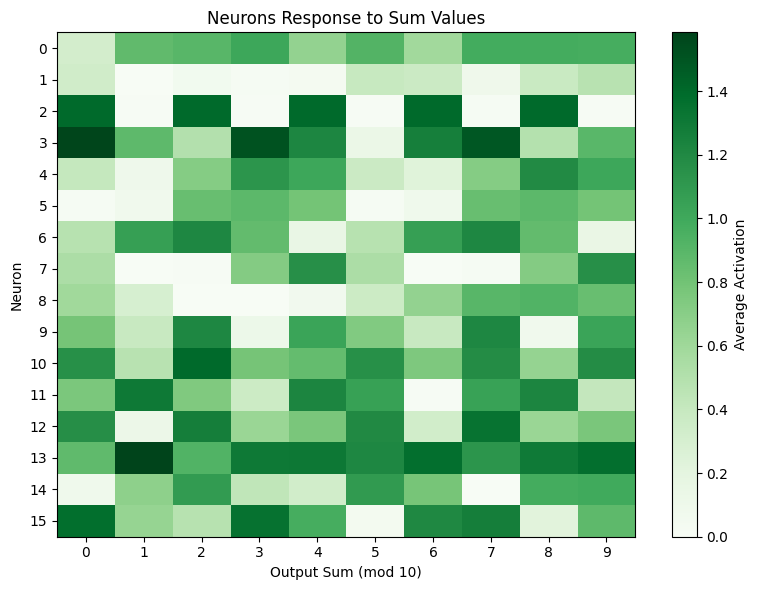

In [69]:
# Create heatmap
neuron_by_sum = np.zeros((16, 10))  # 16 neurons, 10 possible sums

for idx in range(len(X_train)):
    a = idx // 10
    b = idx % 10
    sum_val = (a + b) % 10
    neuron_by_sum[:, sum_val] += activations[idx]

# Average by how many times each sum appears
sum_counts = np.bincount(y_train.numpy(), minlength=10)
neuron_by_sum /= sum_counts[np.newaxis, :]

plt.figure(figsize=(8, 6))
plt.imshow(neuron_by_sum, aspect='auto', cmap='Greens')
plt.colorbar(label='Average Activation')
plt.xlabel('Output Sum (mod 10)')
plt.ylabel('Neuron')
plt.title('Neurons Response to Sum Values')
plt.xticks(range(10))
plt.yticks(range(16))
plt.tight_layout()
plt.show()

When we generate a heatmap, we can see how each neuron responds to each output. Through this visualization technique, it is easier to interpret what each neuron is doing. One neuron that stands out is neuron 2. It has a relatively high activation at 0, 2, 4, 6, and 8. All of these outputs are even so we can infer that neuron 2 is strongly activated each time the sum is even. Neuron 3 has the darkest green squares which indicates that it has the highest average activation across all neurons. It is most activated when the sum is 0, 3, or 7. Although it doesn't cover all prime numbers, we can make a light connection between neuron 3 and sums that equal a prime number. The other darkest green square appears within neuron 13 when the output is 1. This indicates that neuron 13 is mostly responsible for generating the predictions for an output of 1. Neuron 1 seems to be the least activated which could indicate that it isn't essential to the model. If we were to remove this neuron, they hypothesis would be that the model's performance doesn't change much.

## Plot activations according to wraparound cases

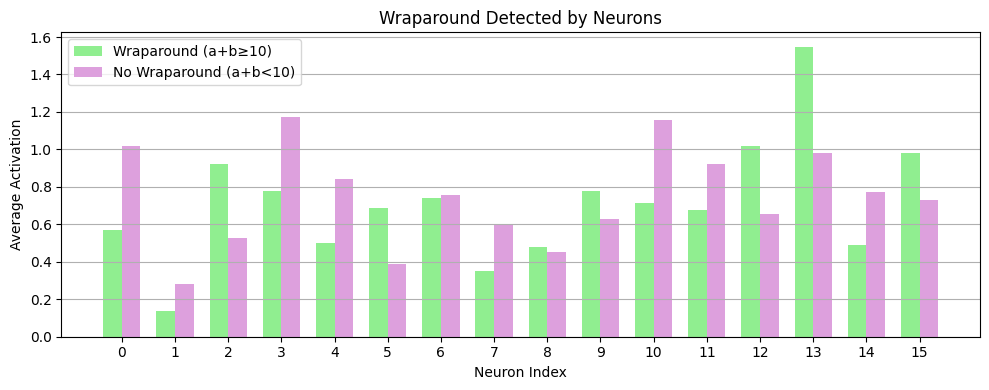


Top 5 wraparound selective neurons:
Neuron 13: Wraparound=1.548, No wraparound=0.980, Difference=0.568
Neuron 0: Wraparound=0.572, No wraparound=1.018, Difference=0.446
Neuron 10: Wraparound=0.713, No wraparound=1.156, Difference=0.443
Neuron 3: Wraparound=0.778, No wraparound=1.172, Difference=0.394
Neuron 2: Wraparound=0.920, No wraparound=0.528, Difference=0.392


In [72]:
# Separate wraparound vs non-wraparound cases
wraparound_mask = []
for idx in range(len(X_train)):
    a = idx // 10
    b = idx % 10
    wraparound_mask.append(a + b >= 10)

wraparound_mask = np.array(wraparound_mask)

# Compare average activations
wrap_acts = activations[wraparound_mask].mean(axis=0)
no_wrap = activations[~wraparound_mask].mean(axis=0)

# Visualize
plt.figure(figsize=(10, 4))
x = np.arange(16)
width = 0.35

plt.bar(x - width/2, wrap_acts, width, label='Wraparound (a+b≥10)', color='lightgreen')
plt.bar(x + width/2, no_wrap, width, label='No Wraparound (a+b<10)', color='plum')

plt.xlabel('Neuron Index')
plt.ylabel('Average Activation')
plt.title('Wraparound Detected by Neurons')
plt.legend()
plt.xticks(range(16))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print top 5 selective neurons
selectivity = np.abs(wrap_acts - no_wrap)
top_neurons = np.argsort(selectivity)[-5:][::-1]
print("\nTop 5 wraparound selective neurons:")
for n in top_neurons:
    print(f"Neuron {n}: Wraparound={wrap_acts[n]:.3f}, No wraparound={no_wrap[n]:.3f}, Difference={selectivity[n]:.3f}")

Another concept we are concerned with in modular arithmetics is wraparound cases. When the sum exceeds our modular value (10), the output cycles back to 0 similar to how a clock functions with the number 12. I wanted to see if there were any specific neurons that were responsible for dealing with wraparound cases. I also printed the top 5 neurons that seemed to be biased towards wrapwround cases. This was calculated by taking the difference between wraparound and non-wraparound cases that a neuron dealth with. Our results show that neuron 13 is the most selective with wraparound cases. If we refer to the heatmap above, neuron 13 is activated the most when the output is 1. This value is the first value that comes when an algorithm has to reset the cycle to 0. By combining these two observations, we can infer that neuron 13 plays a crucial role in the model's transition to predicting wraparound cases.

## Part 4 - Reflect

I learned that my model doesn't solely rely on one neuron to generate the predictions. As shown in the bar graph, it was hard to notice a trend which shows that multiple neurons contribute to each possible pair, even though it may be a simple mathematical function. It was also interesting to see that not all 16 neurons were equally utilized. This could indicate that my model is efficient and does not need to utilize all neurons to generate predictions.

Since my selected task was a mathematical concept, I expected to see obvious trends in how the neurons were activated since the calculation was straightforward. However, I saw sparse activation with no clear pattern which was surprising to me. It was also interesting to see that several neurons seem to be activated more strongly when dealing with a wraparound case where the sum is greater than 10. This implies that my model discovered a key computational step and trained on it.

One part that was hard to understand is the possible interactions between neurons. It was easy for me to interpret how one neuron was activated, but it was challenging when I had to explore how multiple neurons interacted together for one specific output. As shown in the heatmap, sevearl neurons also don't have a clear pattern on when they would be 'on' or 'off' so it was hard to explain what that specific neuron was doing.

If I were to explore this further, I would want to see how different architectures of neural networks could impact the activation of neurons. Additionally, within the concept of modular arithmetic, it would be interesting to explore how changing the modular value would affect the model's performance.